# Importing Packages

In [1]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create DataFrame with Images

In [4]:
data_path = os.path.join(r'D:\mini\archive (1)', 'data')

images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

# Data Vizualization

In [5]:
data.head()

,image,label
0,D:\mini\archive (1)\data\Blight\Corn_Blight (1...,Blight
1,D:\mini\archive (1)\data\Blight\Corn_Blight (1...,Blight
2,D:\mini\archive (1)\data\Blight\Corn_Blight (1...,Blight
3,D:\mini\archive (1)\data\Blight\Corn_Blight (1...,Blight
4,D:\mini\archive (1)\data\Blight\Corn_Blight (1...,Blight


In [6]:
data.shape

(4188, 2)

In [7]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.81, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [8]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (3392, 2)
Validation set shape: (398, 2)
Test set shape: (398, 2)


In [9]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 3392 validated image filenames belonging to 4 classes.
Found 398 validated image filenames belonging to 4 classes.
Found 398 validated image filenames belonging to 4 classes.


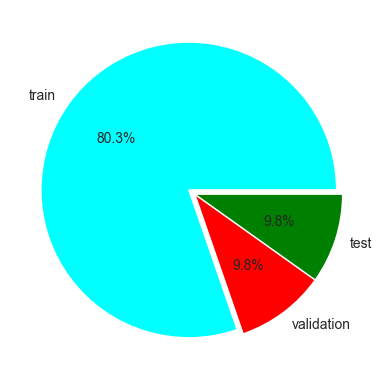

<Figure size 640x480 with 0 Axes>

In [10]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.show()
plt.savefig('dataset_pie.png')

In [11]:
print(train_gen.class_indices)
print(test_gen.class_indices)
print(valid_gen.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}
{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


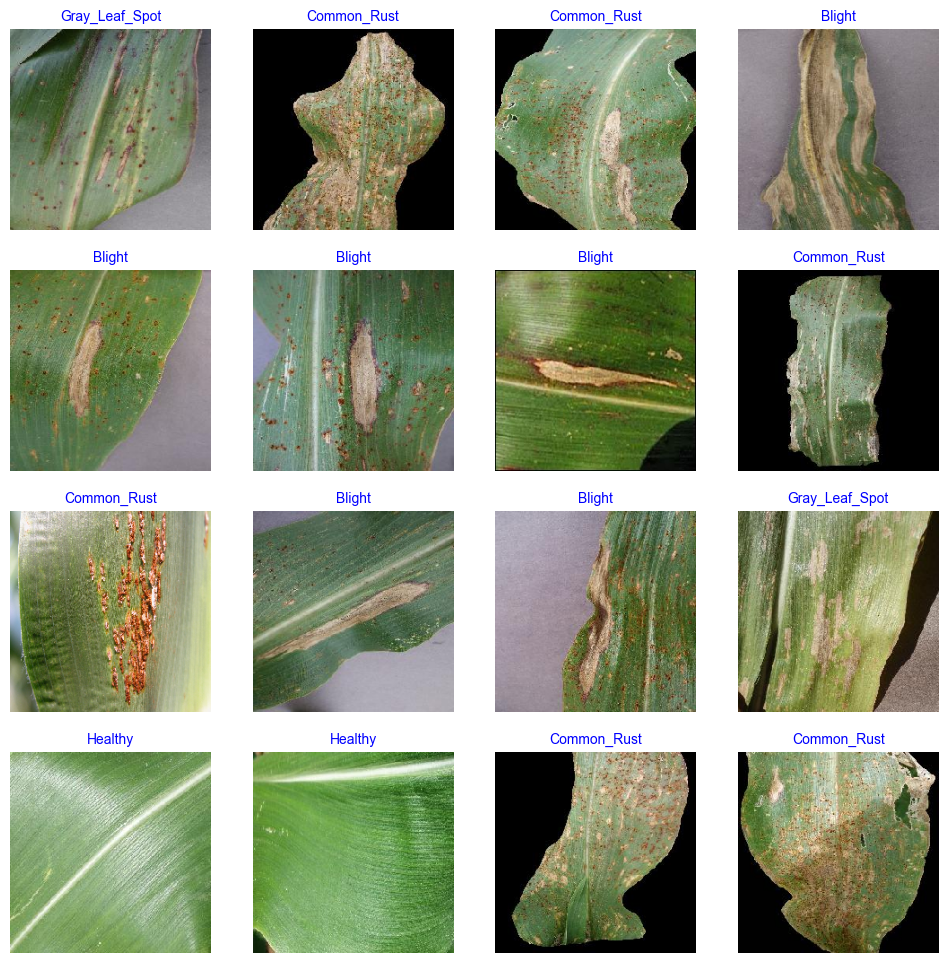

In [12]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

# CNN Model

In [13]:
model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))


model.add(Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))



model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 110, 110, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 430,212 (1.64 MB)

 Trainable params: 429,572 (1.64 MB)

 Non-trainable params: 640 (2.50 KB)

# Callbacks and Model Compile

In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.6894 - loss: 0.8506 - val_accuracy: 0.2462 - val_loss: 1.6755
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.8185 - loss: 0.4685 - val_accuracy: 0.6709 - val_loss: 0.8666
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.8704 - loss: 0.3753 - val_accuracy: 0.7060 - val_loss: 0.7545
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.8833 - loss: 0.3353 - val_accuracy: 0.8543 - val_loss: 0.4052
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.9045 - loss: 0.2827 - val_accuracy: 0.8643 - val_loss: 0.4633
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 368s 3s/step - accuracy: 0.9187 - loss: 0.2586 - val_accuracy: 0.8618 - val_loss: 0.4398
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.9213 - loss: 0.2429 - val_accuracy: 0.8643 - val_loss: 0.4272
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9307 - loss: 0.2177 - 

# Accuracy and Loss Curve

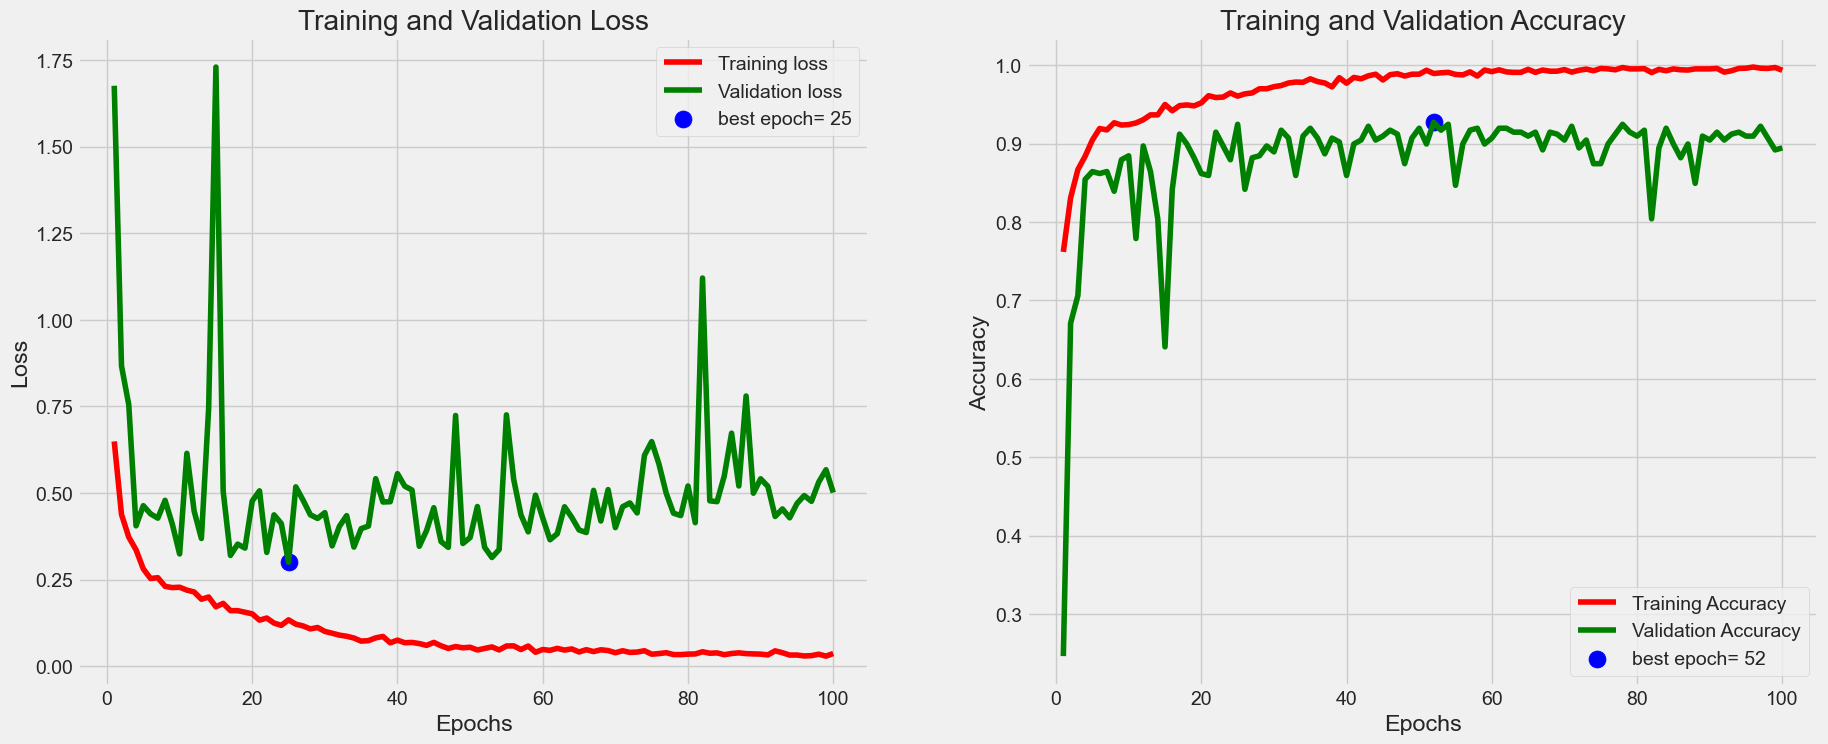

In [16]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


# Accuracy Score

In [17]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 635ms/step - accuracy: 0.8896 - loss: 0.5582
Accuracy score: 0.8944723606109619


In [18]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

199/199 ━━━━━━━━━━━━━━━━━━━━ 115s 575ms/step - accuracy: 0.9942 - loss: 0.0358
199/199 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.8950 - loss: 0.4972  
199/199 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.9197 - loss: 0.3862
Train Loss:  0.037294454872608185
Train Accuracy:  0.9935141801834106
--------------------
Valid Loss:  0.5009887218475342
Valid Accuracy:  0.8944723606109619
--------------------
Test Loss:  0.3868686258792877
Test Accuracy:  0.9195979833602905


# Classification Report

In [23]:
y_pred_proba = model.predict(test_gen) 
y_pred = np.argmax(y_pred_proba, axis=1)
print(classification_report(test_gen.classes, y_pred, target_names= classes))

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 830ms/step
                precision    recall  f1-score   support

        Blight       0.90      0.86      0.88       109
   Common_Rust       0.96      0.94      0.95       124
Gray_Leaf_Spot       0.81      0.81      0.81        54
       Healthy       0.95      1.00      0.97       111

      accuracy                           0.92       398
     macro avg       0.90      0.91      0.90       398
  weighted avg       0.92      0.92      0.92       398



# Confusion Matrix

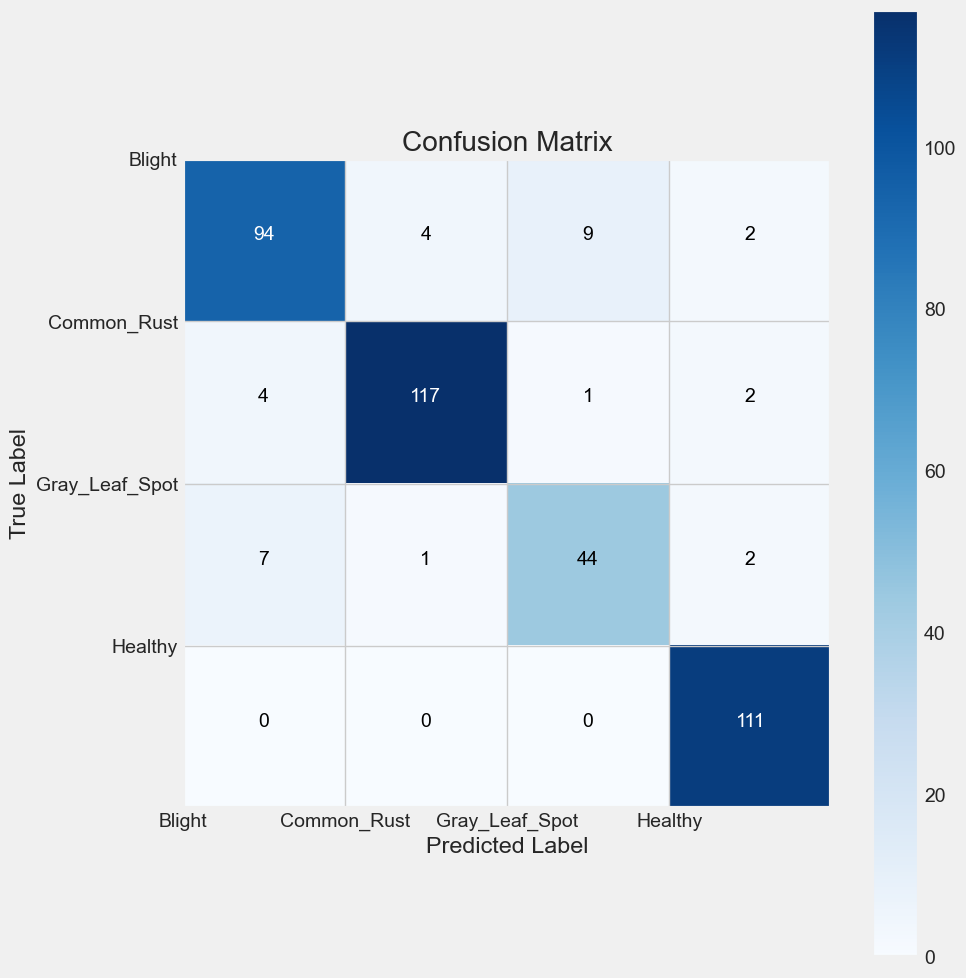

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks - 0.5, classes)
plt.yticks(tick_marks - 0.5, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

# Model Save

In [25]:
model.save('model2.h5')

# ROC Curve

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 651ms/step


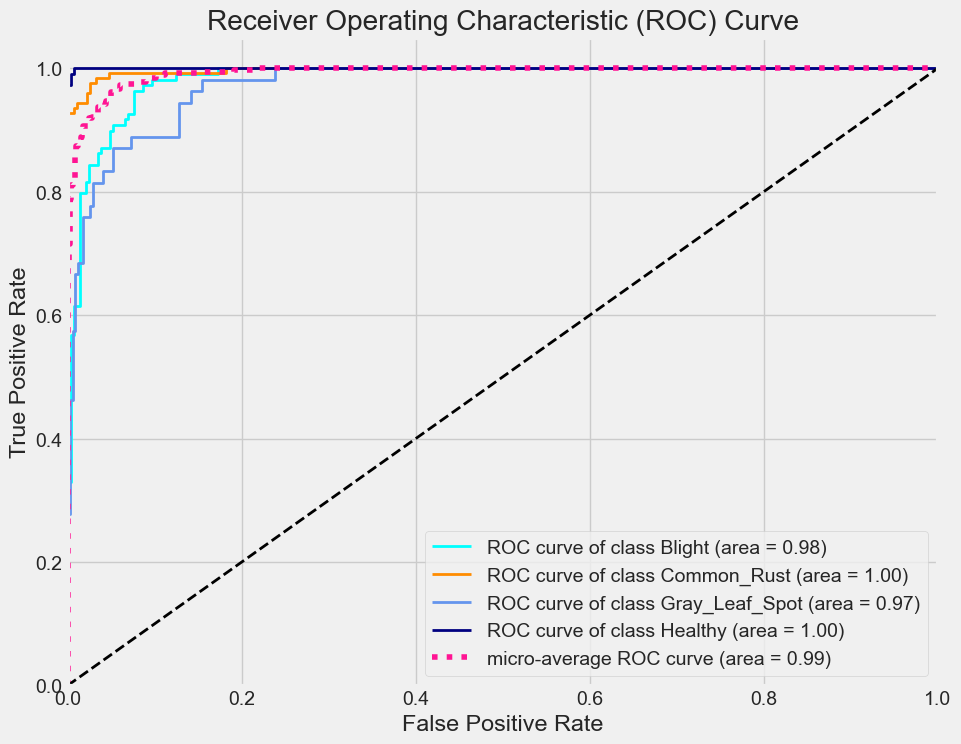

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_gen.classes, classes=range(n_classes))
y_pred_probs = model.predict(test_gen)  # Ensure these are the predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# AUC Curve

In [27]:
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class Blight: 0.98
AUC for class Common_Rust: 1.00
AUC for class Gray_Leaf_Spot: 0.97
AUC for class Healthy: 1.00
Micro-average AUC: 0.99
Macro-average AUC: 0.99


# RestNet50 Model

In [28]:
from keras.applications import ResNet50
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = resnet_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
resnet_model = Model(inputs, outputs)

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']

)

resnet_model.fit(train_gen, epochs=3, validation_data=valid_gen)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7753 - loss: 0.6212 - val_accuracy: 0.9095 - val_loss: 0.2405
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9145 - loss: 0.2248 - val_accuracy: 0.8945 - val_loss: 0.2442
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9204 - loss: 0.1884 - val_accuracy: 0.9347 - val_loss: 0.1912


In [29]:
test_loss, test_acc = resnet_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.927135705947876   loss:  0.1547524780035019


13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


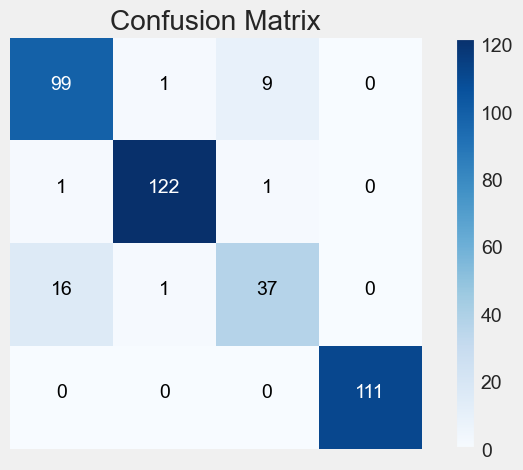

In [30]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

test_preds = resnet_model.predict(test_gen)
predicted_labels = np.argmax(test_preds, axis=1)

cm = confusion_matrix(test_gen.classes, predicted_labels)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = list(test_gen.class_indices.keys())
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Remove the axes
plt.gca().set_axis_off()
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')

plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


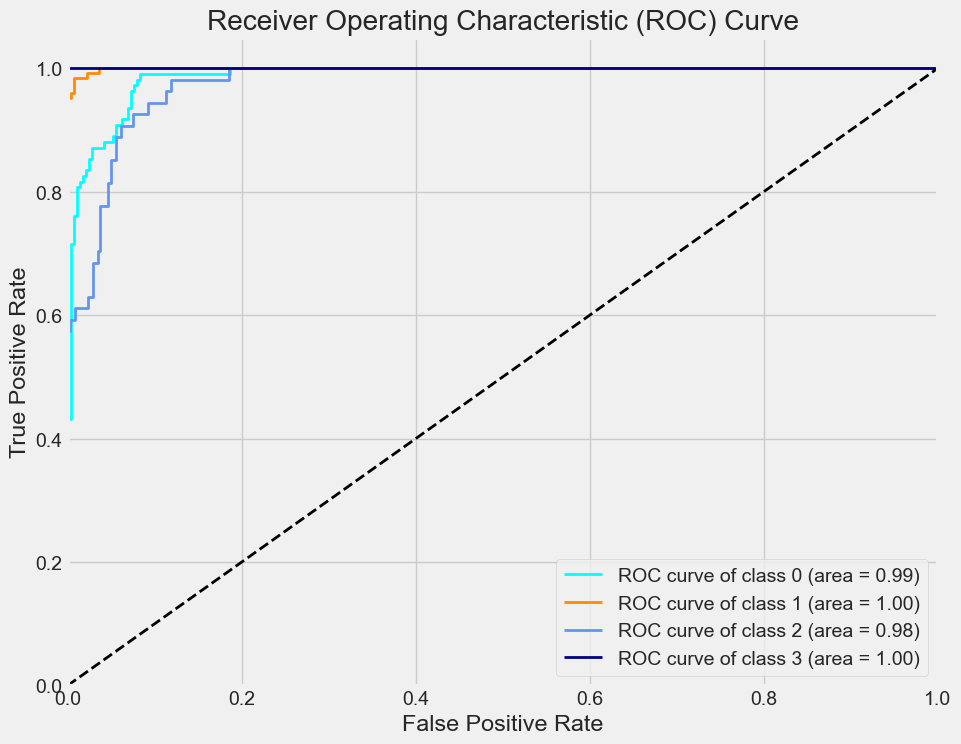

AUC for class 0: 0.99
AUC for class 1: 1.00
AUC for class 2: 0.98
AUC for class 3: 1.00
Micro-averaged AUC: 1.00


In [31]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

true_labels = label_binarize(test_gen.classes, classes=[0, 1, 2, 3])
n_classes = true_labels.shape[1]

predicted_probs = resnet_model.predict(test_gen)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

for i in range(n_classes):
    print(f'AUC for class {i}: {roc_auc[i]:.2f}')
print(f'Micro-averaged AUC: {roc_auc["micro"]:.2f}')

# VG616 Model

In [32]:
from keras.applications import VGG16
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = vgg16_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
vgg16_model = Model(inputs, outputs)

vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg16_model.fit(train_gen, epochs=3, validation_data=valid_gen)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Epoch 1/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 489s 5s/step - accuracy: 0.6360 - loss: 2.3521 - val_accuracy: 0.8844 - val_loss: 0.3290
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.8560 - loss: 0.3835 - val_accuracy: 0.8819 - val_loss: 0.3157
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 493s 5s/step - accuracy: 0.8812 - loss: 0.2950 - val_accuracy: 0.9121 - val_loss: 0.2745


In [33]:
test_loss, test_acc = vgg16_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.9070351719856262   loss:  0.22446322441101074


# MobileNetV2 Model

In [34]:
from keras.applications import MobileNetV2
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenetv2_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = mobilenetv2_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
mobilenetv2_model = Model(inputs, outputs)

mobilenetv2_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenetv2_model.fit(train_gen, epochs=3, validation_data=valid_gen)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 72s 645ms/step - accuracy: 0.7034 - loss: 0.7776 - val_accuracy: 0.8166 - val_loss: 0.4221
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 574ms/step - accuracy: 0.8237 - loss: 0.4161 - val_accuracy: 0.8291 - val_loss: 0.3737
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 578ms/step - accuracy: 0.8407 - loss: 0.3667 - val_accuracy: 0.8291 - val_loss: 0.3701


In [35]:
test_loss, test_acc = mobilenetv2_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.8643215894699097   loss:  0.3167039453983307


# DenseNet121 Model

In [36]:
from keras.applications import DenseNet121
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

densenet121_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
densenet121_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = densenet121_base(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)
densenet121_model = Model(inputs, outputs)

densenet121_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

densenet121_model.fit(train_gen, epochs=3, validation_data=valid_gen)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.6591 - loss: 1.5606 - val_accuracy: 0.8417 - val_loss: 0.3755
Epoch 2/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.8284 - loss: 0.4212 - val_accuracy: 0.8417 - val_loss: 0.3369
Epoch 3/3
106/106 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.8531 - loss: 0.3388 - val_accuracy: 0.8668 - val_loss: 0.3126


In [37]:
test_loss, test_acc = densenet121_model.evaluate(test_gen, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.8793969750404358   loss:  0.27085283398628235


# Lime using VGG16 model

In [40]:
!pip install lime

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 429.7 kB/s eta 0:00:29
   - -------------------------------------- 0.5/12.8 MB 429.7 kB/s eta 0:00:29
   -- ------------------------------------- 0.8/12.8 MB 493.2 kB/s eta 0:00:25
   -- ------------------------------------- 0.8/12.8 MB 493.2 kB/s eta 0:00:25
   --- ------------------------------------ 1.0/12.8 MB 513.7 kB/s eta 0:00:23
   --- -----------

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 10/1000 [00:01<02:31,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  3%|▎         | 29/1000 [00:02<01:18, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


  3%|▎         | 34/1000 [00:03<01:50,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  4%|▍         | 40/1000 [00:05<02:12,  7.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


  5%|▌         | 50/1000 [00:06<02:00,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  6%|▌         | 60/1000 [00:07<01:58,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  7%|▋         | 70/1000 [00:08<01:55,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  9%|▊         | 86/1000 [00:09<01:28, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  9%|▉         | 90/1000 [00:10<01:59,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|█         | 100/1000 [00:12<01:54,  7.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 11%|█         | 110/1000 [00:13<01:47,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 12%|█▏        | 120/1000 [00:14<01:45,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 14%|█▍        | 138/1000 [00:15<01:16, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


 15%|█▍        | 147/1000 [00:16<01:21, 10.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▌        | 158/1000 [00:18<01:17, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 16%|█▌        | 162/1000 [00:19<02:02,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 17%|█▋        | 170/1000 [00:20<02:11,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 189/1000 [00:22<01:23,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█▉        | 193/1000 [00:23<01:55,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 20%|██        | 200/1000 [00:25<02:06,  6.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 21%|██        | 210/1000 [00:26<01:59,  6.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 228/1000 [00:28<01:28,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 23%|██▎       | 232/1000 [00:29<02:02,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 24%|██▍       | 240/1000 [00:31<02:05,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 25%|██▌       | 250/1000 [00:32<01:55,  6.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 26%|██▌       | 260/1000 [00:33<01:47,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 27%|██▋       | 270/1000 [00:34<01:40,  7.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 288/1000 [00:36<01:14,  9.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 29%|██▉       | 291/1000 [00:37<01:41,  7.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|███       | 300/1000 [00:38<01:38,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 318/1000 [00:40<01:08,  9.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 32%|███▏      | 322/1000 [00:41<01:32,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 34%|███▎      | 336/1000 [00:42<01:14,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 35%|███▍      | 347/1000 [00:44<01:18,  8.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▌      | 359/1000 [00:46<01:08,  9.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 36%|███▋      | 364/1000 [00:47<01:38,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 37%|███▋      | 370/1000 [00:49<01:52,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 388/1000 [00:50<01:09,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 39%|███▉      | 392/1000 [00:51<01:35,  6.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 406/1000 [00:53<01:13,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 41%|████      | 410/1000 [00:54<01:38,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 42%|████▏     | 420/1000 [00:55<01:27,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▎     | 437/1000 [00:57<01:01,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 44%|████▍     | 441/1000 [00:58<01:26,  6.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 46%|████▌     | 457/1000 [01:00<01:02,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 469/1000 [01:01<00:56,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 47%|████▋     | 473/1000 [01:03<01:20,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 48%|████▊     | 480/1000 [01:04<01:25,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 49%|████▉     | 490/1000 [01:05<01:15,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 50%|█████     | 500/1000 [01:06<01:09,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 518/1000 [01:08<00:48,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 52%|█████▏    | 522/1000 [01:09<01:03,  7.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 53%|█████▎    | 530/1000 [01:10<01:05,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 54%|█████▍    | 540/1000 [01:12<01:01,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 557/1000 [01:13<00:45,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 56%|█████▌    | 560/1000 [01:14<01:02,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 57%|█████▋    | 570/1000 [01:15<00:58,  7.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▊    | 587/1000 [01:17<00:42,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 59%|█████▉    | 591/1000 [01:18<00:57,  7.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 60%|██████    | 600/1000 [01:19<00:57,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 62%|██████▏   | 616/1000 [01:21<00:43,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 629/1000 [01:22<00:38,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 63%|██████▎   | 633/1000 [01:24<00:53,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 65%|██████▍   | 647/1000 [01:26<00:44,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 658/1000 [01:27<00:42,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 66%|██████▌   | 662/1000 [01:28<00:55,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 677/1000 [01:30<00:38,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 68%|██████▊   | 681/1000 [01:31<00:51,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 70%|██████▉   | 697/1000 [01:33<00:34,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████   | 709/1000 [01:34<00:30,  9.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 71%|███████▏  | 714/1000 [01:35<00:40,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 728/1000 [01:37<00:28,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 73%|███████▎  | 732/1000 [01:38<00:38,  6.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 74%|███████▍  | 740/1000 [01:39<00:38,  6.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 75%|███████▌  | 750/1000 [01:40<00:34,  7.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 77%|███████▋  | 767/1000 [01:42<00:23,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 778/1000 [01:43<00:22,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 78%|███████▊  | 782/1000 [01:44<00:31,  7.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|███████▉  | 797/1000 [01:46<00:22,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 80%|████████  | 801/1000 [01:47<00:30,  6.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 818/1000 [01:49<00:19,  9.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 82%|████████▏ | 822/1000 [01:50<00:26,  6.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 83%|████████▎ | 830/1000 [01:51<00:25,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▍ | 849/1000 [01:53<00:14, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 85%|████████▌ | 853/1000 [01:54<00:20,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 86%|████████▌ | 860/1000 [01:55<00:21,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 88%|████████▊ | 879/1000 [01:57<00:12,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 889/1000 [01:58<00:12,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 89%|████████▉ | 893/1000 [02:00<00:17,  6.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 907/1000 [02:01<00:11,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 91%|█████████ | 911/1000 [02:03<00:14,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 927/1000 [02:04<00:08,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 93%|█████████▎| 931/1000 [02:05<00:10,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 94%|█████████▍| 940/1000 [02:06<00:08,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 957/1000 [02:08<00:04,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 96%|█████████▌| 961/1000 [02:09<00:05,  6.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 979/1000 [02:11<00:02,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 98%|█████████▊| 983/1000 [02:12<00:02,  6.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 99%|█████████▉| 990/1000 [02:13<00:01,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s]


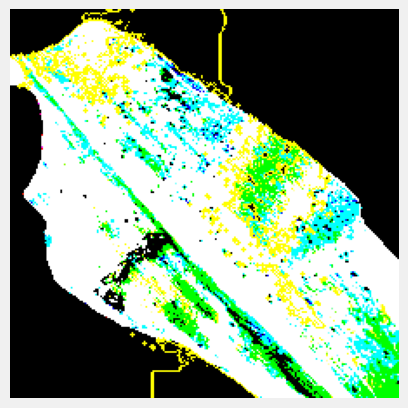

In [44]:
import lime
import lime.lime_image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = VGG16(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img_path = r"D:\mini\archive (1)\data\Common_Rust\Corn_Common_Rust (100).JPG"

img = np.array(Image.open(img_path).resize((224, 224)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.axis('off')
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

# Lime using ResNet50 Model

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  1%|          | 10/1000 [00:02<03:42,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  2%|▏         | 20/1000 [00:02<02:02,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


  3%|▎         | 30/1000 [00:03<01:30, 10.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


  4%|▍         | 40/1000 [00:03<01:15, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


  5%|▌         | 50/1000 [00:04<01:06, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


  6%|▌         | 60/1000 [00:05<01:01, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


  7%|▋         | 70/1000 [00:05<00:58, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


  8%|▊         | 80/1000 [00:06<00:56, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


  9%|▉         | 90/1000 [00:06<00:55, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 10%|█         | 100/1000 [00:07<00:55, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 11%|█         | 110/1000 [00:08<00:57, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 12%|█▏        | 120/1000 [00:08<00:56, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 13%|█▎        | 130/1000 [00:09<00:54, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


 14%|█▍        | 140/1000 [00:09<00:53, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 16%|█▌        | 159/1000 [00:10<00:41, 20.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 16%|█▋        | 163/1000 [00:11<00:54, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


 18%|█▊        | 178/1000 [00:12<00:45, 18.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 19%|█▊        | 187/1000 [00:12<00:50, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


 20%|█▉        | 198/1000 [00:13<00:47, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 20%|██        | 202/1000 [00:14<01:03, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 22%|██▏       | 219/1000 [00:15<00:45, 17.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


 22%|██▏       | 224/1000 [00:15<00:57, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 24%|██▍       | 238/1000 [00:16<00:47, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 24%|██▍       | 243/1000 [00:17<01:01, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 25%|██▌       | 250/1000 [00:17<01:03, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step


 27%|██▋       | 269/1000 [00:18<00:40, 18.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 28%|██▊       | 279/1000 [00:19<00:42, 16.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


 28%|██▊       | 283/1000 [00:20<00:57, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 30%|██▉       | 299/1000 [00:20<00:38, 17.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 30%|███       | 304/1000 [00:21<00:49, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


 32%|███▏      | 319/1000 [00:22<00:37, 18.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 32%|███▏      | 324/1000 [00:22<00:47, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 34%|███▍      | 339/1000 [00:23<00:35, 18.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 35%|███▍      | 349/1000 [00:24<00:37, 17.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 35%|███▌      | 353/1000 [00:24<00:52, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 36%|███▋      | 364/1000 [00:25<00:46, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step


 38%|███▊      | 378/1000 [00:26<00:35, 17.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 39%|███▉      | 389/1000 [00:27<00:34, 17.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 40%|███▉      | 398/1000 [00:28<00:40, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 41%|████      | 409/1000 [00:28<00:39, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 41%|████▏     | 413/1000 [00:29<00:52, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 43%|████▎     | 428/1000 [00:30<00:35, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 43%|████▎     | 432/1000 [00:31<00:47, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 45%|████▍     | 447/1000 [00:31<00:33, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


 45%|████▌     | 451/1000 [00:32<00:42, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 47%|████▋     | 469/1000 [00:33<00:27, 19.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 47%|████▋     | 474/1000 [00:33<00:36, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 49%|████▉     | 488/1000 [00:34<00:29, 17.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 49%|████▉     | 492/1000 [00:35<00:39, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 51%|█████     | 508/1000 [00:35<00:28, 17.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


 51%|█████     | 512/1000 [00:36<00:37, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step


 53%|█████▎    | 527/1000 [00:37<00:28, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 53%|█████▎    | 531/1000 [00:37<00:37, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


 55%|█████▍    | 546/1000 [00:38<00:27, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step


 56%|█████▌    | 557/1000 [00:39<00:25, 17.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 57%|█████▋    | 568/1000 [00:40<00:24, 17.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 57%|█████▋    | 573/1000 [00:40<00:31, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


 59%|█████▉    | 589/1000 [00:41<00:22, 18.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step


 59%|█████▉    | 594/1000 [00:42<00:27, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 61%|██████    | 608/1000 [00:42<00:21, 18.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


 62%|██████▏   | 616/1000 [00:43<00:24, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


 63%|██████▎   | 628/1000 [00:44<00:20, 18.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


 63%|██████▎   | 633/1000 [00:44<00:27, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 65%|██████▍   | 648/1000 [00:45<00:19, 17.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


 65%|██████▌   | 652/1000 [00:46<00:26, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


 67%|██████▋   | 668/1000 [00:46<00:18, 18.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 67%|██████▋   | 672/1000 [00:47<00:24, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step


 69%|██████▉   | 688/1000 [00:48<00:17, 17.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 69%|██████▉   | 693/1000 [00:49<00:22, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 70%|███████   | 705/1000 [00:49<00:20, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 72%|███████▏  | 718/1000 [00:50<00:16, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 72%|███████▏  | 722/1000 [00:51<00:23, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 74%|███████▍  | 738/1000 [00:52<00:16, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


 74%|███████▍  | 742/1000 [00:52<00:21, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


 76%|███████▌  | 758/1000 [00:53<00:14, 17.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 76%|███████▋  | 763/1000 [00:54<00:17, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 78%|███████▊  | 777/1000 [00:55<00:13, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


 79%|███████▊  | 786/1000 [00:55<00:13, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


 80%|███████▉  | 796/1000 [00:56<00:12, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step


 81%|████████  | 808/1000 [00:57<00:10, 18.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 81%|████████▏ | 813/1000 [00:57<00:14, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


 83%|████████▎ | 828/1000 [00:58<00:10, 17.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 84%|████████▍ | 839/1000 [00:59<00:09, 17.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step


 84%|████████▍ | 844/1000 [01:00<00:12, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 86%|████████▌ | 857/1000 [01:00<00:09, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 87%|████████▋ | 869/1000 [01:01<00:07, 17.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 87%|████████▋ | 874/1000 [01:02<00:10, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 89%|████████▊ | 887/1000 [01:03<00:07, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 90%|████████▉ | 898/1000 [01:04<00:06, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 90%|█████████ | 902/1000 [01:04<00:08, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step


 92%|█████████▏| 918/1000 [01:05<00:04, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step


 93%|█████████▎| 929/1000 [01:06<00:04, 17.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


 93%|█████████▎| 934/1000 [01:06<00:05, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


 95%|█████████▍| 947/1000 [01:07<00:03, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 95%|█████████▌| 954/1000 [01:08<00:03, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


 97%|█████████▋| 968/1000 [01:09<00:01, 17.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 98%|█████████▊| 979/1000 [01:09<00:01, 17.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 98%|█████████▊| 983/1000 [01:10<00:01, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step


100%|█████████▉| 997/1000 [01:11<00:00, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


100%|██████████| 1000/1000 [01:12<00:00, 13.87it/s]


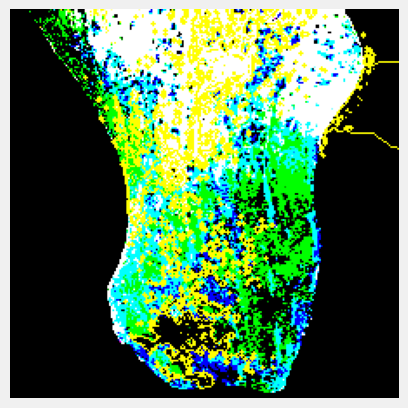

In [46]:
import lime
import lime.lime_image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = ResNet50(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img_path = r"D:\mini\archive (1)\data\Common_Rust\Corn_Common_Rust (1000).JPG"

img = np.array(Image.open(img_path).resize((224, 224)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')

plt.show()

# Lime using InceptionV3 Model

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  1%|          | 10/1000 [00:02<04:24,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


  2%|▏         | 20/1000 [00:03<02:24,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


  3%|▎         | 30/1000 [00:03<01:44,  9.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


  4%|▍         | 40/1000 [00:04<01:29, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


  6%|▌         | 59/1000 [00:05<00:58, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


  6%|▋         | 63/1000 [00:06<01:26, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


  7%|▋         | 74/1000 [00:07<01:30, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


  9%|▉         | 89/1000 [00:08<01:03, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


  9%|▉         | 93/1000 [00:09<01:25, 10.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 11%|█         | 109/1000 [00:10<01:00, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 11%|█▏        | 114/1000 [00:11<01:17, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


 13%|█▎        | 129/1000 [00:11<00:57, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


 13%|█▎        | 134/1000 [00:12<01:13, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 14%|█▍        | 140/1000 [00:13<01:22, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 16%|█▌        | 158/1000 [00:14<01:00, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


 17%|█▋        | 169/1000 [00:15<01:03, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 17%|█▋        | 173/1000 [00:16<01:27,  9.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step


 18%|█▊        | 185/1000 [00:17<01:18, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step


 19%|█▉        | 190/1000 [00:18<01:36,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 20%|██        | 200/1000 [00:19<01:23,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 22%|██▏       | 219/1000 [00:20<00:52, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 22%|██▏       | 223/1000 [00:21<01:09, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 23%|██▎       | 230/1000 [00:21<01:16, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


 25%|██▍       | 249/1000 [00:23<00:52, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


 25%|██▌       | 253/1000 [00:23<01:09, 10.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 27%|██▋       | 268/1000 [00:24<00:53, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 27%|██▋       | 272/1000 [00:25<01:22,  8.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 28%|██▊       | 280/1000 [00:26<01:20,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


 29%|██▉       | 290/1000 [00:27<01:13,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 31%|███       | 306/1000 [00:29<01:07, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 31%|███▏      | 314/1000 [00:30<01:18,  8.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


 33%|███▎      | 327/1000 [00:31<01:02, 10.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 34%|███▎      | 336/1000 [00:33<01:09,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


 35%|███▍      | 347/1000 [00:34<01:02, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


 36%|███▌      | 359/1000 [00:35<00:53, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


 37%|███▋      | 368/1000 [00:36<00:57, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


 37%|███▋      | 372/1000 [00:37<01:19,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


 39%|███▊      | 386/1000 [00:38<00:56, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


 39%|███▉      | 390/1000 [00:39<01:18,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 40%|████      | 400/1000 [00:40<01:06,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 42%|████▏     | 419/1000 [00:41<00:41, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


 42%|████▏     | 423/1000 [00:42<00:51, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 43%|████▎     | 430/1000 [00:42<00:52, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 44%|████▍     | 440/1000 [00:43<00:47, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


 45%|████▌     | 450/1000 [00:44<00:43, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 46%|████▌     | 460/1000 [00:44<00:41, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 47%|████▋     | 470/1000 [00:45<00:40, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step


 48%|████▊     | 480/1000 [00:46<00:38, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 49%|████▉     | 490/1000 [00:47<00:37, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


 51%|█████     | 508/1000 [00:48<00:29, 16.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 51%|█████     | 512/1000 [00:48<00:37, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


 52%|█████▏    | 520/1000 [00:49<00:38, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


 54%|█████▍    | 538/1000 [00:50<00:30, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 54%|█████▍    | 542/1000 [00:51<00:38, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 55%|█████▌    | 550/1000 [00:51<00:38, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 56%|█████▌    | 560/1000 [00:52<00:35, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step


 57%|█████▋    | 570/1000 [00:53<00:34, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 58%|█████▊    | 580/1000 [00:54<00:33, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


 60%|█████▉    | 598/1000 [00:55<00:25, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


 60%|██████    | 602/1000 [00:56<00:33, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 61%|██████    | 610/1000 [00:56<00:33, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 62%|██████▏   | 620/1000 [00:57<00:31, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


 64%|██████▎   | 637/1000 [00:58<00:24, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


 64%|██████▍   | 641/1000 [00:59<00:31, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


 66%|██████▌   | 659/1000 [01:00<00:22, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


 66%|██████▋   | 663/1000 [01:01<00:31, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 68%|██████▊   | 678/1000 [01:02<00:23, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 68%|██████▊   | 682/1000 [01:03<00:31, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


 70%|██████▉   | 698/1000 [01:04<00:22, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 70%|███████   | 702/1000 [01:04<00:29, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


 71%|███████   | 710/1000 [01:05<00:29,  9.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 73%|███████▎  | 729/1000 [01:06<00:18, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


 73%|███████▎  | 733/1000 [01:07<00:23, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 75%|███████▍  | 747/1000 [01:08<00:17, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


 75%|███████▌  | 751/1000 [01:09<00:24, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


 76%|███████▋  | 764/1000 [01:10<00:21, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step


 78%|███████▊  | 777/1000 [01:11<00:16, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


 78%|███████▊  | 781/1000 [01:11<00:21, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 80%|███████▉  | 797/1000 [01:12<00:14, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 80%|████████  | 801/1000 [01:13<00:20,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 81%|████████  | 810/1000 [01:14<00:18, 10.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 82%|████████▏ | 820/1000 [01:15<00:16, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 83%|████████▎ | 830/1000 [01:16<00:14, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 85%|████████▍ | 849/1000 [01:17<00:09, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


 86%|████████▌ | 857/1000 [01:17<00:10, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


 87%|████████▋ | 869/1000 [01:18<00:08, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step


 87%|████████▋ | 873/1000 [01:19<00:12, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


 88%|████████▊ | 880/1000 [01:20<00:12,  9.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 89%|████████▉ | 890/1000 [01:21<00:10, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 90%|█████████ | 900/1000 [01:22<00:08, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 92%|█████████▏| 919/1000 [01:22<00:04, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 92%|█████████▏| 923/1000 [01:23<00:06, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 93%|█████████▎| 934/1000 [01:24<00:05, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step


 95%|█████████▍| 948/1000 [01:25<00:03, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


 95%|█████████▌| 952/1000 [01:26<00:04, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


 96%|█████████▌| 960/1000 [01:27<00:03, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


 97%|█████████▋| 970/1000 [01:27<00:02, 10.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 98%|█████████▊| 980/1000 [01:28<00:01, 11.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


100%|█████████▉| 999/1000 [01:29<00:00, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


100%|██████████| 1000/1000 [01:30<00:00, 11.06it/s]


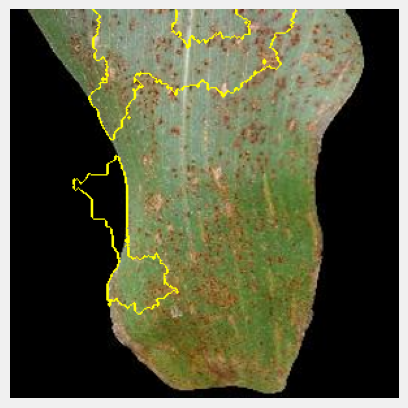

In [47]:
import lime
import lime.lime_image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = InceptionV3(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img_path = r"D:\mini\archive (1)\data\Common_Rust\Corn_Common_Rust (1000).JPG"

img = np.array(Image.open(img_path).resize((299, 299)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()

# Lime using MobileNetV2 Model

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  1%|          | 10/1000 [00:02<04:31,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  2%|▏         | 20/1000 [00:03<02:07,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


  3%|▎         | 30/1000 [00:03<01:23, 11.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  4%|▍         | 40/1000 [00:03<00:59, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


  5%|▌         | 50/1000 [00:03<00:46, 20.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


  6%|▌         | 60/1000 [00:04<00:38, 24.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  7%|▋         | 70/1000 [00:04<00:33, 28.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


  8%|▊         | 80/1000 [00:04<00:28, 31.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


  9%|▉         | 90/1000 [00:04<00:27, 33.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 10%|█         | 100/1000 [00:05<00:24, 36.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 11%|█         | 110/1000 [00:05<00:23, 38.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 12%|█▏        | 120/1000 [00:05<00:22, 39.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 13%|█▎        | 130/1000 [00:05<00:22, 39.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 14%|█▍        | 140/1000 [00:06<00:20, 40.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 15%|█▌        | 150/1000 [00:06<00:21, 38.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 16%|█▌        | 160/1000 [00:06<00:21, 38.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 17%|█▋        | 170/1000 [00:06<00:20, 40.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


 18%|█▊        | 180/1000 [00:07<00:19, 42.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


 19%|█▉        | 190/1000 [00:07<00:18, 43.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 20%|██        | 200/1000 [00:07<00:18, 43.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


 21%|██        | 210/1000 [00:07<00:17, 44.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 22%|██▏       | 220/1000 [00:07<00:17, 45.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


 23%|██▎       | 230/1000 [00:08<00:16, 45.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 24%|██▍       | 240/1000 [00:08<00:16, 46.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


 25%|██▌       | 250/1000 [00:08<00:16, 45.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


 26%|██▌       | 260/1000 [00:08<00:16, 44.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 27%|██▋       | 270/1000 [00:09<00:16, 44.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


 28%|██▊       | 280/1000 [00:09<00:16, 44.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 29%|██▉       | 290/1000 [00:09<00:16, 44.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 30%|███       | 300/1000 [00:09<00:15, 44.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 31%|███       | 310/1000 [00:09<00:15, 44.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 32%|███▏      | 320/1000 [00:10<00:15, 44.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 33%|███▎      | 330/1000 [00:10<00:14, 44.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 34%|███▍      | 340/1000 [00:10<00:15, 43.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 35%|███▌      | 350/1000 [00:10<00:15, 42.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 36%|███▌      | 360/1000 [00:11<00:15, 41.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 37%|███▋      | 370/1000 [00:11<00:15, 40.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 38%|███▊      | 380/1000 [00:11<00:15, 39.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 39%|███▉      | 390/1000 [00:11<00:15, 39.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 40%|████      | 400/1000 [00:12<00:15, 37.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 41%|████      | 410/1000 [00:12<00:16, 36.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 42%|████▏     | 420/1000 [00:12<00:15, 37.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 43%|████▎     | 430/1000 [00:12<00:14, 38.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 44%|████▍     | 440/1000 [00:13<00:14, 39.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 45%|████▌     | 450/1000 [00:13<00:13, 40.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


 46%|████▌     | 460/1000 [00:13<00:12, 42.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


 47%|████▋     | 470/1000 [00:13<00:12, 43.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 48%|████▊     | 480/1000 [00:14<00:12, 42.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 49%|████▉     | 490/1000 [00:14<00:12, 42.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 50%|█████     | 500/1000 [00:14<00:12, 39.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 51%|█████     | 510/1000 [00:14<00:12, 38.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 52%|█████▏    | 520/1000 [00:15<00:12, 37.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 53%|█████▎    | 530/1000 [00:15<00:12, 38.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


 54%|█████▍    | 540/1000 [00:15<00:12, 38.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 55%|█████▌    | 550/1000 [00:15<00:11, 38.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 56%|█████▌    | 560/1000 [00:16<00:11, 39.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 57%|█████▋    | 570/1000 [00:16<00:10, 40.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 58%|█████▊    | 580/1000 [00:16<00:10, 40.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 59%|█████▉    | 590/1000 [00:16<00:10, 40.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 60%|██████    | 600/1000 [00:17<00:09, 40.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 61%|██████    | 610/1000 [00:17<00:09, 39.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 62%|██████▏   | 620/1000 [00:17<00:09, 38.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 63%|██████▎   | 630/1000 [00:18<00:10, 36.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 64%|██████▍   | 640/1000 [00:18<00:09, 37.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 65%|██████▌   | 650/1000 [00:18<00:09, 37.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 66%|██████▌   | 660/1000 [00:18<00:09, 36.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 67%|██████▋   | 670/1000 [00:19<00:09, 36.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 68%|██████▊   | 680/1000 [00:19<00:08, 37.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 69%|██████▉   | 690/1000 [00:19<00:08, 38.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 70%|███████   | 700/1000 [00:19<00:07, 40.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 71%|███████   | 710/1000 [00:20<00:07, 40.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


 72%|███████▏  | 720/1000 [00:20<00:06, 41.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 73%|███████▎  | 730/1000 [00:20<00:06, 41.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 74%|███████▍  | 740/1000 [00:20<00:06, 41.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


 75%|███████▌  | 750/1000 [00:21<00:05, 41.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 76%|███████▌  | 760/1000 [00:21<00:06, 39.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


 77%|███████▋  | 770/1000 [00:21<00:05, 39.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


 78%|███████▊  | 780/1000 [00:21<00:05, 40.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 79%|███████▉  | 790/1000 [00:22<00:05, 39.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


 80%|████████  | 800/1000 [00:22<00:05, 39.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


 81%|████████  | 810/1000 [00:22<00:04, 39.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 82%|████████▏ | 820/1000 [00:22<00:04, 39.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


 83%|████████▎ | 830/1000 [00:23<00:04, 39.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


 84%|████████▍ | 840/1000 [00:23<00:04, 39.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


 85%|████████▌ | 850/1000 [00:23<00:03, 39.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


 86%|████████▌ | 860/1000 [00:23<00:03, 40.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 87%|████████▋ | 870/1000 [00:24<00:03, 39.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


 88%|████████▊ | 880/1000 [00:24<00:03, 38.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 89%|████████▉ | 890/1000 [00:24<00:02, 39.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


 90%|█████████ | 900/1000 [00:24<00:02, 38.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 91%|█████████ | 910/1000 [00:25<00:02, 38.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 92%|█████████▏| 920/1000 [00:25<00:02, 37.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 93%|█████████▎| 930/1000 [00:25<00:02, 34.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 94%|█████████▍| 940/1000 [00:26<00:01, 34.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 95%|█████████▌| 950/1000 [00:26<00:01, 34.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 96%|█████████▌| 960/1000 [00:26<00:01, 34.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


 97%|█████████▋| 970/1000 [00:27<00:01, 29.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 98%|█████████▊| 980/1000 [00:27<00:00, 27.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 99%|█████████▉| 990/1000 [00:27<00:00, 27.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


100%|██████████| 1000/1000 [00:28<00:00, 35.46it/s]


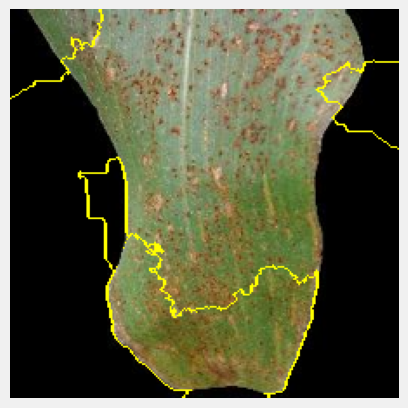

In [49]:
import lime
import lime.lime_image
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from skimage.segmentation import mark_boundaries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = MobileNetV2(weights='imagenet')

explainer = lime.lime_image.LimeImageExplainer()

img_path = r"D:\mini\archive (1)\data\Common_Rust\Corn_Common_Rust (1000).JPG"


img = np.array(Image.open(img_path).resize((224, 224)))
img = preprocess_input(img)

explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()

# Lime using custom CNN model

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step


  1%|          | 10/1000 [00:00<00:59, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


  2%|▏         | 20/1000 [00:00<00:44, 21.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


  3%|▎         | 30/1000 [00:01<00:38, 24.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


  4%|▍         | 40/1000 [00:01<00:36, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


  5%|▌         | 50/1000 [00:01<00:33, 28.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


  6%|▌         | 60/1000 [00:02<00:32, 28.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


  7%|▋         | 70/1000 [00:02<00:31, 29.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


  8%|▊         | 80/1000 [00:02<00:30, 30.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


  9%|▉         | 90/1000 [00:03<00:29, 30.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 10%|█         | 100/1000 [00:03<00:29, 30.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 11%|█         | 110/1000 [00:03<00:29, 30.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 12%|█▏        | 120/1000 [00:04<00:28, 30.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 13%|█▎        | 130/1000 [00:04<00:29, 29.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 14%|█▍        | 140/1000 [00:04<00:28, 30.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 15%|█▌        | 150/1000 [00:05<00:27, 30.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 16%|█▌        | 160/1000 [00:05<00:26, 31.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 17%|█▋        | 170/1000 [00:05<00:26, 31.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 18%|█▊        | 180/1000 [00:06<00:26, 30.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 19%|█▉        | 190/1000 [00:06<00:25, 31.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 20%|██        | 200/1000 [00:06<00:25, 31.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 21%|██        | 210/1000 [00:07<00:25, 30.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 22%|██▏       | 220/1000 [00:07<00:26, 29.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 23%|██▎       | 230/1000 [00:07<00:28, 27.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 24%|██▍       | 240/1000 [00:08<00:27, 27.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


 25%|██▌       | 250/1000 [00:08<00:28, 26.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


 26%|██▌       | 260/1000 [00:09<00:27, 26.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 27%|██▋       | 270/1000 [00:09<00:26, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 28%|██▊       | 280/1000 [00:09<00:25, 27.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 29%|██▉       | 290/1000 [00:10<00:24, 28.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


 30%|███       | 300/1000 [00:10<00:24, 28.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 31%|███       | 310/1000 [00:10<00:24, 27.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


 32%|███▏      | 320/1000 [00:11<00:25, 26.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 33%|███▎      | 330/1000 [00:11<00:24, 27.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


 34%|███▍      | 340/1000 [00:11<00:24, 26.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 35%|███▌      | 350/1000 [00:12<00:23, 27.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 36%|███▌      | 360/1000 [00:12<00:22, 28.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


 37%|███▋      | 370/1000 [00:12<00:22, 28.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 38%|███▊      | 380/1000 [00:13<00:22, 27.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 39%|███▉      | 390/1000 [00:13<00:21, 28.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


 40%|████      | 400/1000 [00:14<00:21, 28.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 41%|████      | 410/1000 [00:14<00:20, 28.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 42%|████▏     | 420/1000 [00:14<00:20, 28.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 43%|████▎     | 430/1000 [00:15<00:20, 27.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


 44%|████▍     | 440/1000 [00:15<00:20, 26.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 45%|████▌     | 450/1000 [00:15<00:20, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


 46%|████▌     | 460/1000 [00:16<00:20, 26.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 47%|████▋     | 470/1000 [00:16<00:20, 26.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 48%|████▊     | 480/1000 [00:17<00:19, 26.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 49%|████▉     | 490/1000 [00:17<00:18, 27.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 50%|█████     | 500/1000 [00:17<00:18, 27.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


 51%|█████     | 510/1000 [00:18<00:17, 27.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 52%|█████▏    | 520/1000 [00:18<00:17, 27.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step


 53%|█████▎    | 530/1000 [00:18<00:17, 27.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 54%|█████▍    | 540/1000 [00:19<00:16, 27.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 55%|█████▌    | 550/1000 [00:19<00:16, 27.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 56%|█████▌    | 560/1000 [00:19<00:16, 27.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 57%|█████▋    | 570/1000 [00:20<00:15, 27.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 58%|█████▊    | 580/1000 [00:20<00:15, 27.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 59%|█████▉    | 590/1000 [00:21<00:14, 27.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 60%|██████    | 600/1000 [00:21<00:14, 28.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 61%|██████    | 610/1000 [00:21<00:13, 28.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 62%|██████▏   | 620/1000 [00:22<00:13, 29.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 63%|██████▎   | 630/1000 [00:22<00:12, 29.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 64%|██████▍   | 640/1000 [00:22<00:12, 29.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 65%|██████▌   | 650/1000 [00:23<00:11, 29.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


 66%|██████▌   | 660/1000 [00:23<00:12, 28.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


 67%|██████▋   | 670/1000 [00:23<00:11, 27.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 68%|██████▊   | 680/1000 [00:24<00:11, 27.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 69%|██████▉   | 690/1000 [00:24<00:10, 28.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 70%|███████   | 700/1000 [00:24<00:10, 28.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


 71%|███████   | 710/1000 [00:25<00:09, 29.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


 72%|███████▏  | 720/1000 [00:25<00:09, 29.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 73%|███████▎  | 730/1000 [00:25<00:09, 29.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


 74%|███████▍  | 740/1000 [00:26<00:08, 29.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 75%|███████▌  | 750/1000 [00:26<00:08, 28.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


 76%|███████▌  | 760/1000 [00:26<00:09, 26.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


 77%|███████▋  | 770/1000 [00:27<00:08, 25.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 78%|███████▊  | 780/1000 [00:27<00:08, 25.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 79%|███████▉  | 790/1000 [00:28<00:08, 25.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


 80%|████████  | 800/1000 [00:28<00:07, 26.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 81%|████████  | 810/1000 [00:28<00:07, 25.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


 82%|████████▏ | 820/1000 [00:29<00:07, 25.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


 83%|████████▎ | 830/1000 [00:29<00:06, 25.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 84%|████████▍ | 840/1000 [00:30<00:06, 25.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


 85%|████████▌ | 850/1000 [00:30<00:06, 24.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 86%|████████▌ | 860/1000 [00:31<00:05, 24.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


 87%|████████▋ | 870/1000 [00:31<00:05, 23.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


 88%|████████▊ | 880/1000 [00:31<00:05, 23.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 89%|████████▉ | 890/1000 [00:32<00:04, 23.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 90%|█████████ | 900/1000 [00:32<00:04, 24.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


 91%|█████████ | 910/1000 [00:33<00:03, 23.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 92%|█████████▏| 920/1000 [00:33<00:03, 23.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


 93%|█████████▎| 930/1000 [00:33<00:02, 23.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


 94%|█████████▍| 940/1000 [00:34<00:02, 23.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


 95%|█████████▌| 950/1000 [00:34<00:02, 23.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


 96%|█████████▌| 960/1000 [00:35<00:01, 23.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


 97%|█████████▋| 970/1000 [00:35<00:01, 23.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


 98%|█████████▊| 980/1000 [00:36<00:00, 24.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step


 99%|█████████▉| 990/1000 [00:36<00:00, 23.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


100%|██████████| 1000/1000 [00:36<00:00, 27.09it/s]


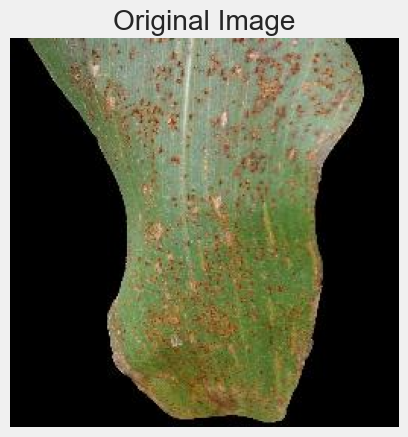

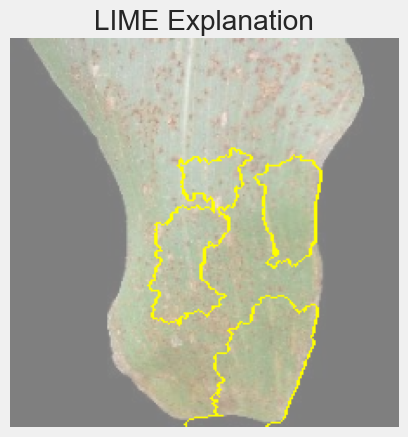

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.models import load_model
import tensorflow as tf

img_path = r"D:\mini\archive (1)\data\Common_Rust\Corn_Common_Rust (1000).JPG"
img = plt.imread(img_path)

def preprocess_image(image):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image.numpy()

preprocessed_img = preprocess_image(img)

model = load_model('D:\mini\model2.h5')

def predict_fn(images):
    processed_images = np.array([preprocess_image(image) for image in images])
    return model.predict(processed_images)

explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(preprocessed_img, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

plt.imshow(img)
plt.axis('off')
plt.title('Original Image')
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.title('LIME Explanation')
plt.show()

# Shap

In [ ]:
!pip install shap

PartitionExplainer explainer: 2it [03:36, 216.61s/it]              


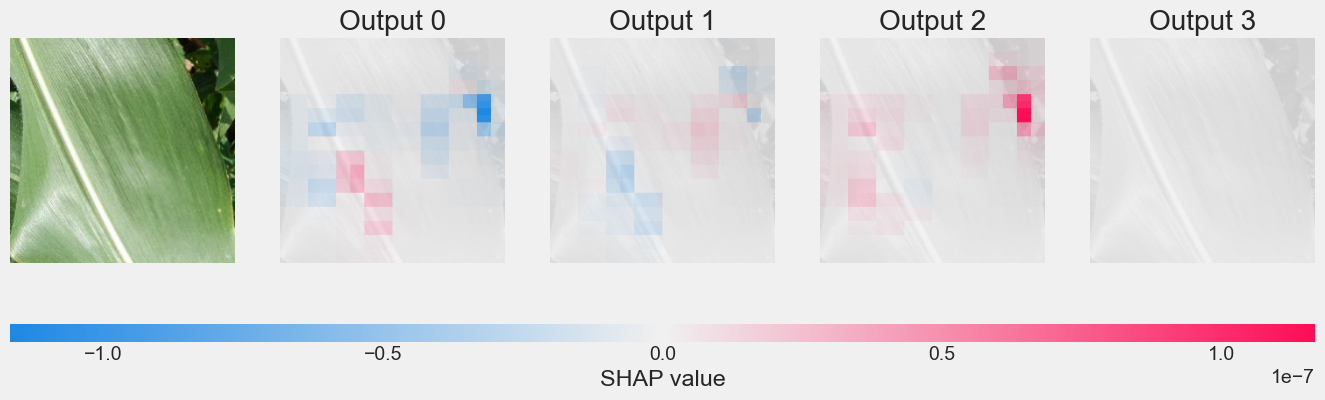

In [55]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.models import load_model

dataset_dir = "D:\mini\archive (1)\data"

img_path = r"D:\mini\archive (1)\data\Common_Rust\Corn_Common_Rust (1000).JPG"

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image.numpy()

image = preprocess_image(image_path)

model = load_model('D:\mini\model2.h5')

def f(x):
    tmp = x.copy()
    return model(tmp)

masker_blur = shap.maskers.Image("blur(224,224)", shape=(224, 224, 3))

explainer_blur = shap.Explainer(f, masker_blur)

shap_values_fine = explainer_blur(image[np.newaxis, :, :, :], max_evals=5000, outputs=shap.Explanation.argsort.flip[:4])

shap.image_plot(shap_values_fine)